# Distance-based treatment effects

Based on the figures from Holodinsky et al. 2017 - "Drip and Ship Versus Direct to Comprehensive Stroke Center"

## Notebook admin

In [1]:
# Import packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Set up MatPlotLib
%matplotlib inline

In [3]:
# Keep notebook cleaner once finalised
import warnings
warnings.filterwarnings('ignore')

# Assumptions 

Fixed times for additional delays:

In [4]:
# All fixed times have units of minutes
fixed_times = dict(
    onset_to_ambulance_arrival = 60,
    ivt_arrival_to_treatment = 30,
    transfer_additional_delay = 60,
    travel_ivt_to_mt = 50,
    mt_arrival_to_treatment = 90,
    )

In [5]:
pd.DataFrame(fixed_times.values(), index=fixed_times.keys(), 
             columns=['Fixed time (minutes)'])

,Fixed time (minutes)
onset_to_ambulance_arrival,60
ivt_arrival_to_treatment,30
transfer_additional_delay,60
travel_ivt_to_mt,50
mt_arrival_to_treatment,90


Patient population:

In [6]:
patient_props = dict(
    lvo = 0.35,
    nlvo = 1.0-0.35, # 1-LVO
    lvo_mt_also_receiving_ivt = 0.85,
    lvo_treated_ivt_only = 0.0,
    lvo_treated_ivt_mt = 0.286,    # 0.286 gives 10% final MT if 35%LVO
    nlvo_treated_ivt_only = 0.155,    # 0.155 gives final 20% IVT
    )

treated_population = (
    patient_props['nlvo'] * patient_props['nlvo_treated_ivt_only'] +
    patient_props['lvo'] * patient_props['lvo_treated_ivt_mt'] +
    patient_props['lvo'] * patient_props['lvo_treated_ivt_only']
    )

patient_props['treated_population'] = treated_population

In [7]:
df_patients = pd.DataFrame(patient_props.values(), 
    index=patient_props.keys(), columns=['Proportion of patient population'])
df_patients['Comment'] = [
    'Proportion of LVO',
    'Proportion of nLVO', 
    'Proportion LVO MT also receiving IVT',
    'Proportion LVO admissions treated with IVT only',
    'Proportion LVO admissions treated with MT',
    'Proportion nLVO admissions treated with IVT',
    'Proportion all admissions treated'
    ]

df_patients

,Proportion of patient population,Comment
lvo,0.35000,Proportion of LVO
nlvo,0.65000,Proportion of nLVO
lvo_mt_also_receiving_ivt,0.85000,Proportion LVO MT also receiving IVT
lvo_treated_ivt_only,0.00000,Proportion LVO admissions treated with IVT only
lvo_treated_ivt_mt,0.28600,Proportion LVO admissions treated with MT
nlvo_treated_ivt_only,0.15500,Proportion nLVO admissions treated with IVT
treated_population,0.20085,Proportion all admissions treated


---

# Define travel time grids

For each point on a grid, find the travel time to a given coordinate (one of the treatment centres).

The treatment centres are located at the following coordinates:

+ IVT centre: (0, 0)
+ IVT/MT centre: (0, $-t_{\mathrm{travel}}^{\mathrm{IVT~to~MT}}$)

In [8]:
ivt_coords = [0, 0]
mt_coords  = [0, -fixed_times['travel_ivt_to_mt']]

Change these parameters:

In [9]:
# Only calculate travel times up to this x or y displacement:
time_travel_max = 80

# Change how granular the grid is. 
grid_step = 1 # minutes

Define a helper function to build the time grid:

In [10]:
def make_time_grid(xy_max, step, x_offset=0, y_offset=0):
    # Times for each row....
    x_times = np.arange(-xy_max, xy_max + step, step) - x_offset
    # ... and each column.
    y_times = np.arange(-xy_max, xy_max + step, step) - y_offset
    # The offsets shift the position of (0,0) from the grid centre 
    # to (x_offset, y_offset). Distances will be calculated from the
    # latter point. 

    # Mesh to create new grids by stacking rows (xx) and columns (yy):
    xx, yy = np.meshgrid(x_times, y_times)

    # Then combine the two temporary grids to find distances: 
    radial_times = np.sqrt(xx**2.0 + yy**2.0)
    return radial_times

Build the grids:

In [11]:
def make_grids_travel_time(time_travel_ivt_to_mt, time_travel_max, ivt_coords, mt_coords, grid_step=1):        
    # Make the grid a bit larger than the max travel time: 
    grid_xy_max = time_travel_max + grid_step*2

    grid_time_travel_directly_to_ivt = make_time_grid(
        grid_xy_max, grid_step, x_offset=ivt_coords[0], 
        y_offset=ivt_coords[1])

    grid_time_travel_directly_to_mt = make_time_grid(
        grid_xy_max, grid_step, x_offset=mt_coords[0], y_offset=mt_coords[1])

    grid_time_travel_directly_diff = (
        grid_time_travel_directly_to_ivt - grid_time_travel_directly_to_mt)

    extent = [-grid_xy_max - grid_step*0.5, 
              +grid_xy_max - grid_step*0.5, 
              -grid_xy_max - grid_step*0.5, 
              +grid_xy_max - grid_step*0.5] 
    
    return (grid_time_travel_directly_to_ivt, 
        grid_time_travel_directly_to_mt,
        grid_time_travel_directly_diff, 
        extent)

In [12]:
(grid_time_travel_directly_to_ivt, 
grid_time_travel_directly_to_mt,
grid_time_travel_directly_diff, 
extent) = make_grids_travel_time(
    fixed_times['travel_ivt_to_mt'], time_travel_max, ivt_coords, mt_coords, grid_step)

---

## Plot travel times

### Grids

In [13]:
from outcome_utilities.geography_plot import plot_two_grids_and_diff

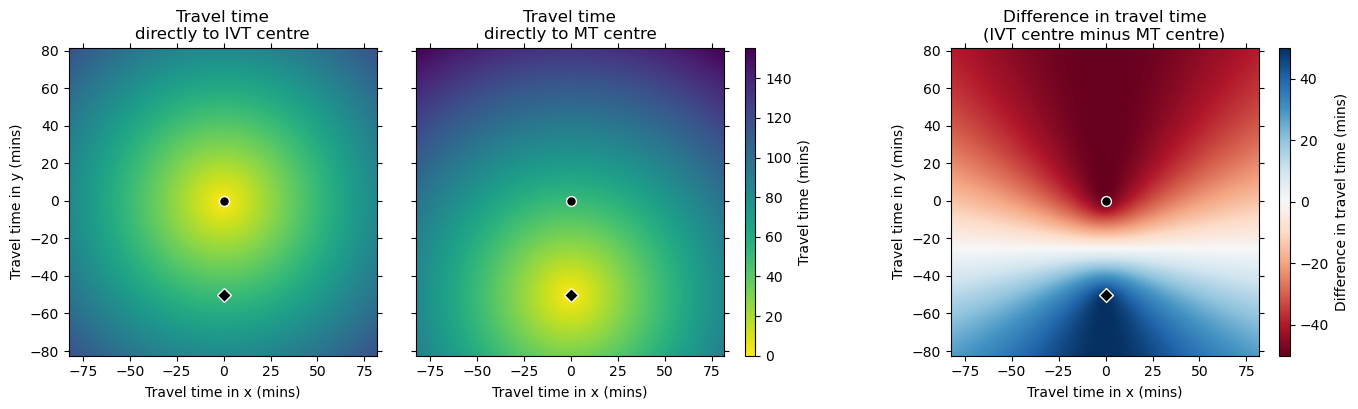

In [14]:
titles = [
    'Travel time'+'\n'+'directly to IVT centre', 
    'Travel time'+'\n'+'directly to MT centre', 
    'Difference in travel time'+'\n'+'(IVT centre minus MT centre)'
    ]

cbar_labels = [
    'Travel time (mins)', 
    'Difference in travel time (mins)'
    ]

plot_two_grids_and_diff(
    grid_time_travel_directly_to_ivt, 
    grid_time_travel_directly_to_mt, 
    grid_time_travel_directly_diff,
    titles=titles, cbar_labels=cbar_labels, 
    extent=extent, cmaps=['viridis_r', 'RdBu'],
    ivt_coords=ivt_coords, mt_coords=mt_coords
    )

On the difference grid, positive values are nearer the IVT/MT centre and negative nearer the IVT-only centre. There is a horizontal line halfway between the two treatment centres that marks where the travel times to the two treatment centres are equal. 

__Presumably the curves in the difference grid match the ones drawn in the Holodinsky et al. 2017 paper.__

### Circle plot

To help define colour limits (`vmin` and `vmax`), gather the coordinates within the largest flattened radiating circle:

In [15]:
from outcome_utilities.geography_plot import find_mask_within_flattened_circle

In [16]:
grid_mask = find_mask_within_flattened_circle(
    grid_time_travel_directly_diff, 
    grid_time_travel_directly_to_ivt, 
    time_travel_max)

coords_valid = np.where(grid_mask<1)

In [17]:
vmin_time = np.nanmin(-grid_time_travel_directly_diff[coords_valid])
vmax_time = np.nanmax(-grid_time_travel_directly_diff[coords_valid])

Update plotting style:

In [18]:
time_step_circle = 5
circ_linewidth = 0.5

In [19]:
from outcome_utilities.geography_plot import circle_plot

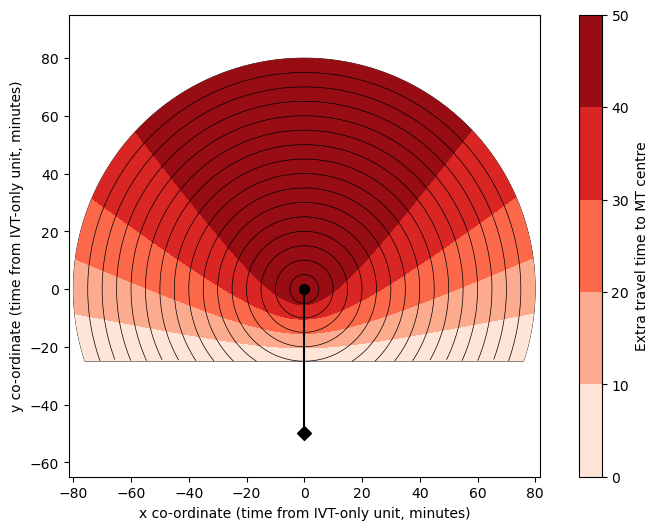

In [20]:
circle_plot(
    -grid_time_travel_directly_diff, fixed_times['travel_ivt_to_mt'], 
    time_travel_max, time_step_circle, vmin_time, vmax_time, imshow=0, 
    cbar_label='Extra travel time to MT centre', extent=extent,
    ivt_coords=ivt_coords, mt_coords=mt_coords, cmap='Reds',
    n_contour_steps=5
    )

---

# Define total time grids (including fixed times for delays)

In [21]:
pd.DataFrame(fixed_times.values(), index=fixed_times.keys(), 
             columns=['Fixed time (minutes)'])

,Fixed time (minutes)
onset_to_ambulance_arrival,60
ivt_arrival_to_treatment,30
transfer_additional_delay,60
travel_ivt_to_mt,50
mt_arrival_to_treatment,90


In [22]:
def make_grids_treatment_time(
    grid_time_travel_directly_to_ivt,
    grid_time_travel_directly_to_mt,
    times_dir):
    """
    Define new treatment time grids. 
    """
    grid_time_ivt_at_ivtcentre = (
        times_dir['onset_to_ambulance_arrival'] + 
        grid_time_travel_directly_to_ivt + 
        times_dir['ivt_arrival_to_treatment']
        )

    grid_time_ivt_at_ivt_then_mt_at_mtcentre = (
        times_dir['onset_to_ambulance_arrival'] + 
        grid_time_travel_directly_to_ivt + 
        times_dir['ivt_arrival_to_treatment'] + 
        times_dir['transfer_additional_delay'] + 
        times_dir['travel_ivt_to_mt'] + 
        times_dir['mt_arrival_to_treatment']
        )

    grid_time_ivt_at_mtcentre = (
        times_dir['onset_to_ambulance_arrival'] + 
        grid_time_travel_directly_to_mt + 
        times_dir['ivt_arrival_to_treatment']
        )

    grid_time_ivt_then_mt_at_mtcentre = (
        times_dir['onset_to_ambulance_arrival'] + 
        grid_time_travel_directly_to_mt + 
        times_dir['ivt_arrival_to_treatment'] + 
        times_dir['mt_arrival_to_treatment']
        )
    return (grid_time_ivt_at_ivtcentre,
            grid_time_ivt_at_ivt_then_mt_at_mtcentre,
            grid_time_ivt_at_mtcentre,
            grid_time_ivt_then_mt_at_mtcentre)

Use this function to define the treatment time grids:

In [23]:
(grid_time_ivt_at_ivtcentre,
grid_time_ivt_at_ivt_then_mt_at_mtcentre,
grid_time_ivt_at_mtcentre,
grid_time_ivt_then_mt_at_mtcentre) = \
make_grids_treatment_time(grid_time_travel_directly_to_ivt,
    grid_time_travel_directly_to_mt, fixed_times)

__check the assumption of time between IVT and MT at the same centre above__

---

## Outcome model

Imports for the clinical outcome model:

In [24]:
from outcome_utilities.clinical_outcome import Clinical_outcome

mrs_dists = pd.read_csv(
    './outcome_utilities/mrs_dist_probs_cumsum.csv', index_col='Stroke type')

# Set up outcome model
outcome_model = Clinical_outcome(mrs_dists)

In [25]:
pd.DataFrame(patient_props.values(), index=patient_props.keys(), 
             columns=['Proportion of patient population'])

,Proportion of patient population
lvo,0.35000
nlvo,0.65000
lvo_mt_also_receiving_ivt,0.85000
lvo_treated_ivt_only,0.00000
lvo_treated_ivt_mt,0.28600
nlvo_treated_ivt_only,0.15500
treated_population,0.20085


Method to find the added utility (c.f. the matrix notebook):

In [26]:
def find_grid_outcomes(outcome_model, grid_time_ivt, grid_time_mt, 
                       patient_props):
    """
    For all pairs of treatment times, calculate the changes in utility
    and mRS for the patient population. 
    
    Inputs:
    
    Returns:
    
    """
    grid_shape = grid_time_ivt.shape
    utility_grid = np.empty(grid_shape)
    mRS_grid = np.empty(grid_shape)

    for row in range(grid_shape[0]):
        for col in range(int(grid_shape[1]*0.5)+1):
            # ^ weird range is for symmetry later when filling grids.
            # Expect col_opp, the opposite column as reflected in the 
            # x=0 axis, to contain the same values as col:
            col_opp = grid_shape[1]-1-col
            
            time_to_ivt = grid_time_ivt[row, col]
            time_to_mt = grid_time_mt[row, col]
            outcomes = outcome_model.calculate_outcomes(
                time_to_ivt, time_to_mt, patients=1000)

            # Find the change in utility:
            added_utility = find_weighted_change(
                outcomes['lvo_ivt_added_utility'],
                outcomes['lvo_mt_added_utility'],
                outcomes['nlvo_ivt_added_utility'],
                patient_props
                )
            # Add this value to the grid:
            utility_grid[row,col] = added_utility
            utility_grid[row,col_opp] = added_utility

            # Find the change in mRS:
            reduced_mRS = find_weighted_change(
                outcomes['lvo_ivt_mean_shift'], 
                outcomes['lvo_mt_mean_shift'],
                outcomes['nlvo_ivt_mean_shift'], 
                patient_props
                )
            # Add this value to the grid:
            mRS_grid[row,col] = reduced_mRS
            mRS_grid[row,col_opp] = reduced_mRS
            
    # Adjust outcome for just treated population
    utility_grid = utility_grid / patient_props['treated_population']
    mRS_grid = mRS_grid / patient_props['treated_population']
    return utility_grid, mRS_grid

In [27]:
def find_weighted_change(change_lvo_ivt, change_lvo_mt, change_nlvo_ivt, 
                         patient_props):
    """
    Take the total changes for each category and calculate their
    weighted sum, where weights are from the proportions of the 
    patient population.
    
    (originally from matrix notebook)
    
    Inputs:
    
    Returns:
    
    """
    # If LVO-IVT is greater change than LVO-MT then adjust MT for 
    # proportion of patients receiving IVT:
    if change_lvo_ivt > change_lvo_mt:
        diff = change_lvo_ivt - change_lvo_mt
        change_lvo_mt += diff * patient_props['lvo_mt_also_receiving_ivt']

    # Calculate changes multiplied by proportions (cp):
    cp_lvo_mt = (
        change_lvo_mt * 
        patient_props['lvo'] * 
        patient_props['lvo_treated_ivt_mt']
        )
    cp_lvo_ivt = (
        change_lvo_ivt * 
        patient_props['lvo'] * 
        patient_props['lvo_treated_ivt_only']
        )
    cp_nlvo_ivt = (
        change_nlvo_ivt * 
        patient_props['nlvo'] * 
        patient_props['nlvo_treated_ivt_only']
        )
        
    total_change = cp_lvo_mt + cp_lvo_ivt + cp_nlvo_ivt
    return total_change

## Grids of changed outcomes

Case 1: IVT at the IVT centre, then MT at the IVT/MT centre

In [28]:
grid_utility_case1, grid_mRS_case1 = find_grid_outcomes(
    outcome_model,
    grid_time_ivt_at_ivtcentre, 
    grid_time_ivt_at_ivt_then_mt_at_mtcentre, 
    patient_props
    )

Case 2: IVT at the IVT/MT centre, then MT at the IVT/MT centre

In [29]:
grid_utility_case2, grid_mRS_case2 = find_grid_outcomes(
    outcome_model,
    grid_time_ivt_at_mtcentre, 
    grid_time_ivt_then_mt_at_mtcentre, 
    patient_props
    )

Difference between them:

In [30]:
grid_utility_diff = grid_utility_case2 - grid_utility_case1
grid_mRS_diff     = grid_mRS_case2     - grid_mRS_case1

---

## Plot the added utility grids

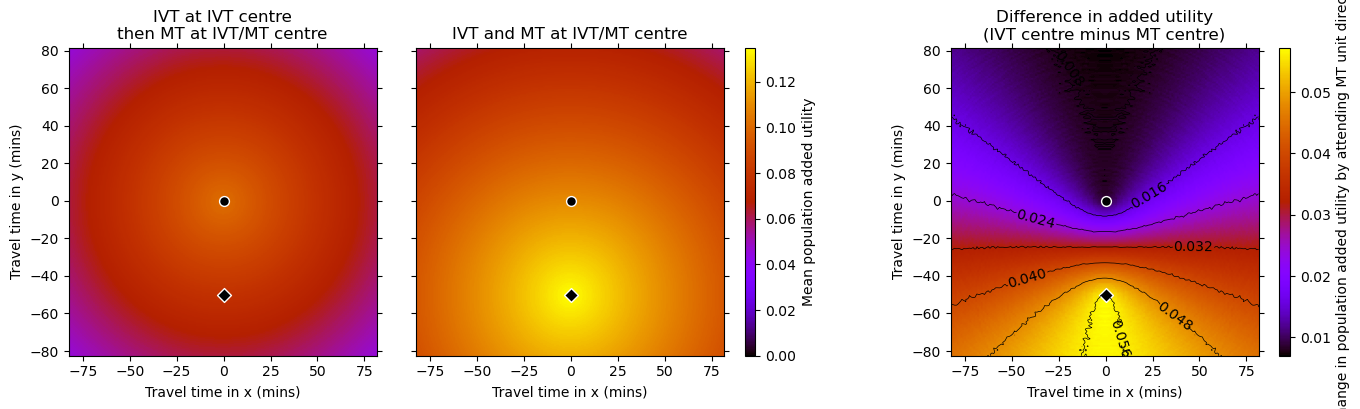

In [31]:
titles = [
    'IVT at IVT centre'+'\n'+'then MT at IVT/MT centre',
    'IVT and MT at IVT/MT centre',
    'Difference in added utility'+'\n'+'(IVT centre minus MT centre)'
    ]

cbar_labels = [
    'Mean population added utility', 
    'Change in population added utility by attending MT unit directly'
    ]

vmin = 0.0 
vmax = np.max([grid_utility_case1, grid_utility_case2])

plot_two_grids_and_diff(
    grid_utility_case1, 
    grid_utility_case2, 
    grid_utility_diff,
    vlims = [[vmin,vmax],[]],
    titles=titles, cbar_labels=cbar_labels, 
    extent=extent, cmaps=['gnuplot','gnuplot'],
    ivt_coords=ivt_coords, mt_coords=mt_coords, plot_contours=1
    )

Getting another horizontal line halfway between the two centres.

Select colour limits for the circle plot:

In [32]:
def round_to_next(vmin, vmax, r=0.005):
    """Round vmin and vmax to nicer values"""
    vmax_r = np.sign(vmax)*np.ceil(np.abs(vmax)/r)*r
    vmin_r = np.floor(vmin/r)*r
    return vmin_r, vmax_r

In [33]:
# Find the actual minumum and maximum values in the grid:
vmin_total = np.nanmin(grid_utility_diff[coords_valid])
vmax_total = np.nanmax(grid_utility_diff[coords_valid])

vmin_util, vmax_util = round_to_next(vmin_total, vmax_total, 0.005)

print('Max. value in grid:', vmax_total)
print('Chosen vmax:       ', vmax_util)
print('Min. value in grid:', vmin_total)
print('Chosen vmin:       ', vmin_util)

Max. value in grid: 0.03292809061488673
Chosen vmax:        0.035
Min. value in grid: 0.007052200647249179
Chosen vmin:        0.005


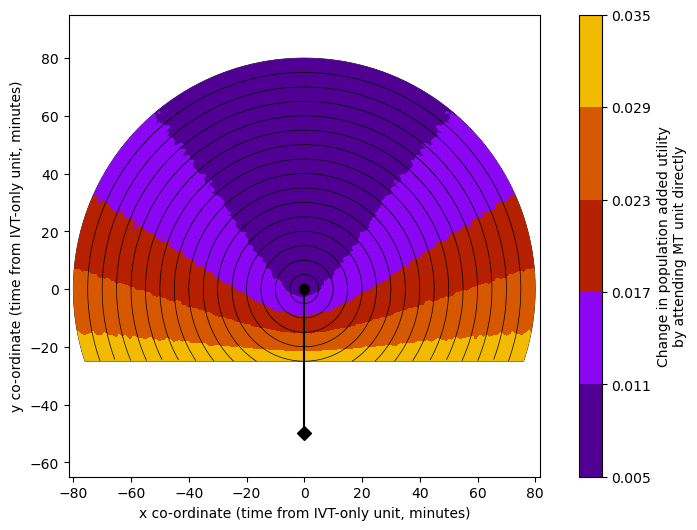

In [34]:
circle_plot(
    grid_utility_diff, fixed_times['travel_ivt_to_mt'], 
    time_travel_max, time_step_circle, vmin_util, vmax_util, imshow=0, 
    cmap='gnuplot', extent=extent,
    cbar_label=('Change in population added utility\n'+
                'by attending MT unit directly'),
    n_contour_steps = 5, 
    # cbar_format_str='{:3.3f}',
    ivt_coords=ivt_coords, mt_coords=mt_coords
    )

---

## Plot the reduced mRS grids

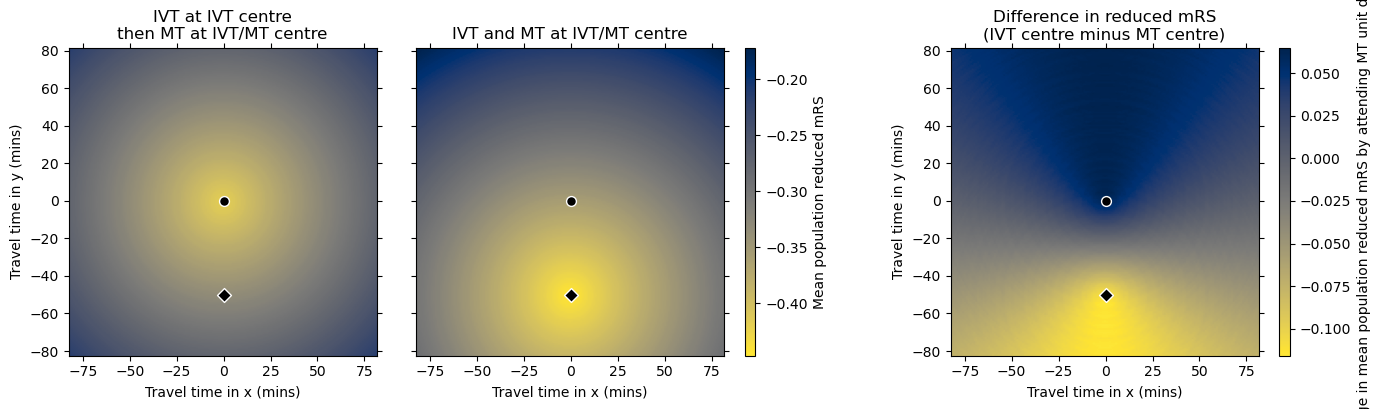

In [35]:
titles = [
    'IVT at IVT centre'+'\n'+'then MT at IVT/MT centre',
    'IVT and MT at IVT/MT centre',
    'Difference in reduced mRS'+'\n'+'(IVT centre minus MT centre)'
    ]

cbar_labels = [
    'Mean population reduced mRS',
    'Change in mean population reduced mRS by attending MT unit directly',
    ]

plot_two_grids_and_diff(
    grid_mRS_case1, 
    grid_mRS_case2, 
    grid_mRS_diff,
    vlims = [[],[]],
    titles=titles, cbar_labels=cbar_labels, 
    extent=extent, cmaps=['cividis_r','cividis_r'],
    ivt_coords=ivt_coords, mt_coords=mt_coords
    )

Getting another horizontal line halfway between the two centres.

Select colour limits for the circle plot:

In [36]:
# Find the actual maximum value in the grid:
vmin_total = np.nanmin(grid_mRS_diff[coords_valid])
vmax_total = np.nanmax(grid_mRS_diff[coords_valid])

# Round this up to the nearest nicer thing of our choice:
vmin_mRS, vmax_mRS = round_to_next(vmin_total, vmax_total, 0.005)

print('Max. value in grid:', vmax_total)
print('Chosen vmax:       ', vmax_mRS)
print('Min. value in grid:', vmin_total)
print('Chosen vmin:       ', vmin_mRS)

Max. value in grid: 0.06490938511326869
Chosen vmax:        0.065
Min. value in grid: -0.02601553398058254
Chosen vmin:        -0.03


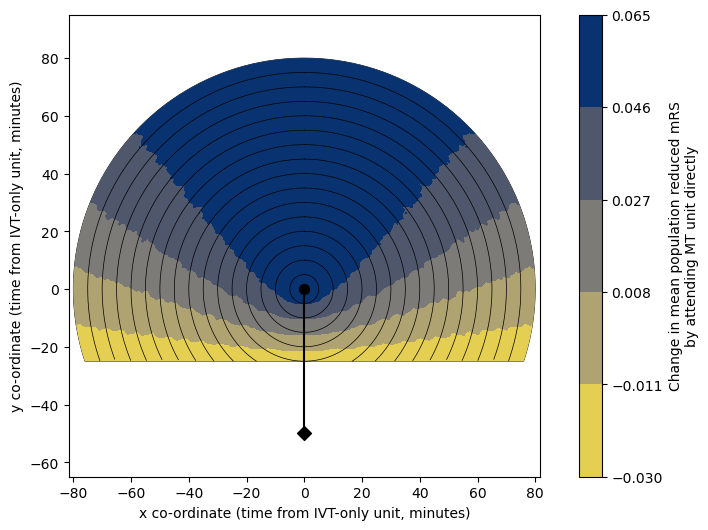

In [37]:
circle_plot(
    grid_mRS_diff, fixed_times['travel_ivt_to_mt'], 
    time_travel_max, time_step_circle, vmin_mRS, vmax_mRS, imshow=0, 
    cmap='cividis_r', extent=extent,
    cbar_label=('Change in mean population reduced mRS\n'+
               'by attending MT unit directly'),
    # cbar_format_str='{:3.2f}', 
    n_contour_steps=5,
    ivt_coords=ivt_coords, mt_coords=mt_coords
    )

---

# Combined circle plot

Condense this notebook into one cell and make a separate figure for each combination of fixed times:

+ Travel time from IVT to MT centre: 30, 60, or 90 mins
+ Onset to ambulance arrival time: 30, 60, or 90 mins

In [38]:
time_list_travel_ivt_to_mt = [30, 60, 90]
time_list_onset_to_ambulance_arrival = [30, 60, 90]

Share these colour limits between all figures:

In [39]:
vmin_time = 0 
vmax_time = np.max(time_list_travel_ivt_to_mt)
vmin_util = -0.014 # -0.045
vmax_util = 0.049 # 0.035
vmin_mRS = -0.090 # -0.250 
vmax_mRS = 0.150 # 0.175

Make new colour maps that are based on a diverging colour map but have the zero (white) off-centre:

In [40]:
from outcome_utilities.geography_plot import make_new_cmap_diverging

cmap_util = make_new_cmap_diverging(
    vmin_util, vmax_util, cmap_base='bwr_r', cmap_name='bwr_util')
cmap_mRS = make_new_cmap_diverging(
    vmin_mRS, vmax_mRS, cmap_base='bwr', cmap_name='bwr_mRS')

# For the time colours, take only the red half of 'bwr':
from matplotlib import colors
colours_time = plt.get_cmap('bwr')(np.linspace(0.5, 1.0, 256))
cmap_time = colors.LinearSegmentedColormap.from_list('bwr_time', colours_time)

Define contour levels for plotting: 

In [41]:
from outcome_utilities.geography_plot import make_levels_with_zeroish

level_step_util = 0.007 # 0.005
levels_util = make_levels_with_zeroish(
    level_step_util, vmax_util, zeroish=1e-3, vmin=vmin_util)

level_step_mRS = 0.03 # 0.025
levels_mRS = make_levels_with_zeroish(
    level_step_mRS, vmax_mRS, zeroish=4e-3, vmin=vmin_mRS)

The following big cell calculates the new grids and then makes the plots.

--------------------------------------------------
Time of travel from IVT to MT: 30
Time from onset to ambulance arrival:  30
Utility  0.0120  0.0274
mRS -0.0220  0.0331


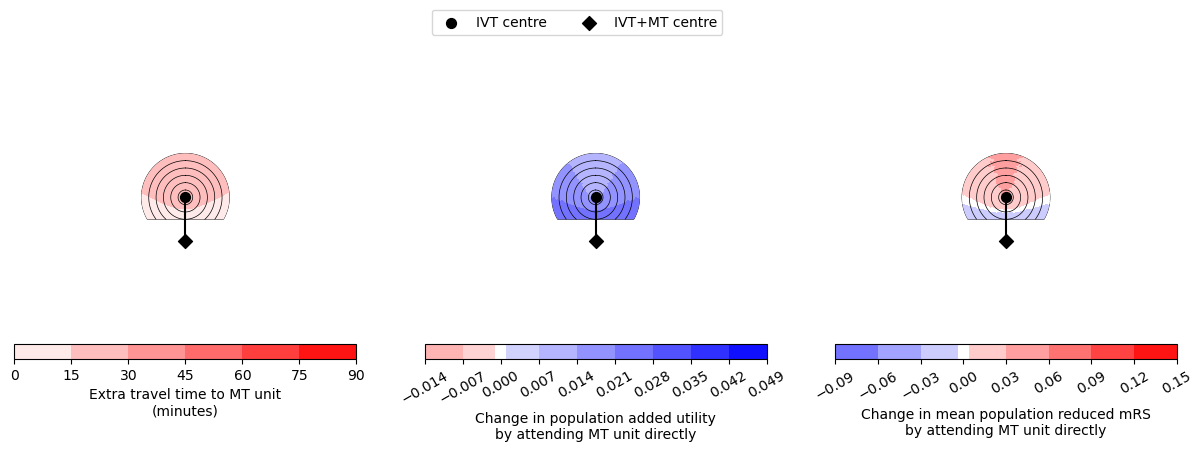

--------------------------------------------------
Time of travel from IVT to MT: 30
Time from onset to ambulance arrival:  60
Utility  0.0118  0.0272
mRS -0.0216  0.0335


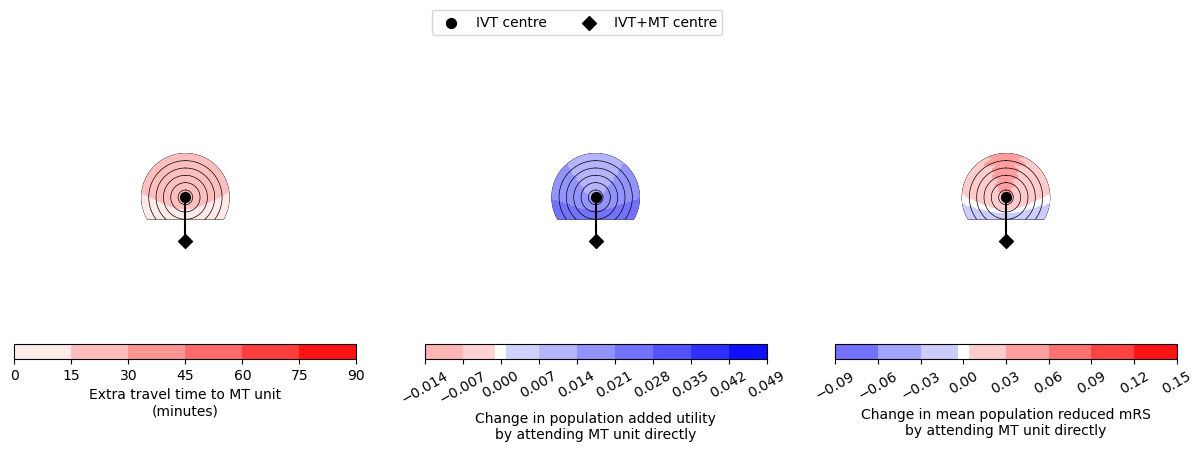

--------------------------------------------------
Time of travel from IVT to MT: 30
Time from onset to ambulance arrival:  90
Utility  0.0114  0.0269
mRS -0.0212  0.0335


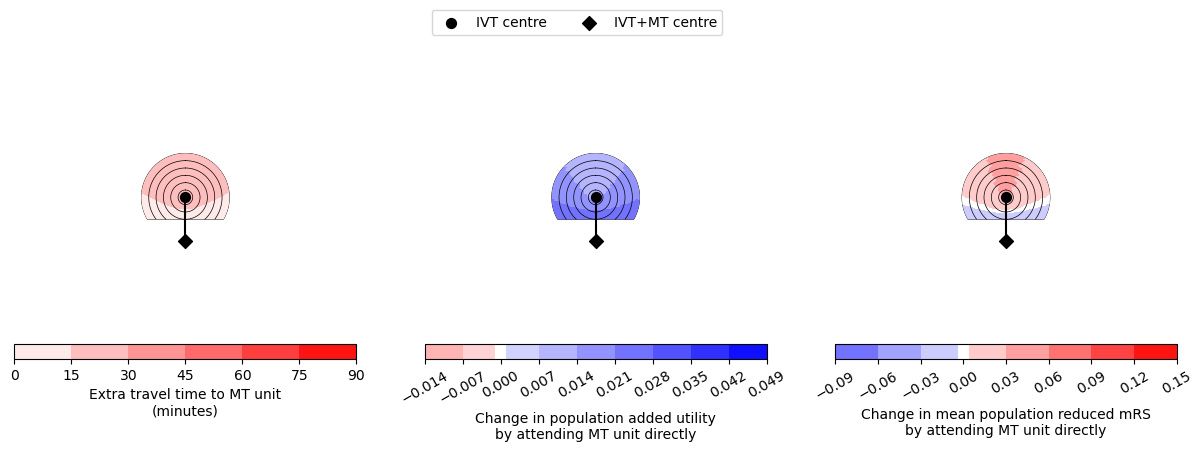

--------------------------------------------------
Time of travel from IVT to MT: 60
Time from onset to ambulance arrival:  30
Utility  0.0058  0.0362
mRS -0.0288  0.0796


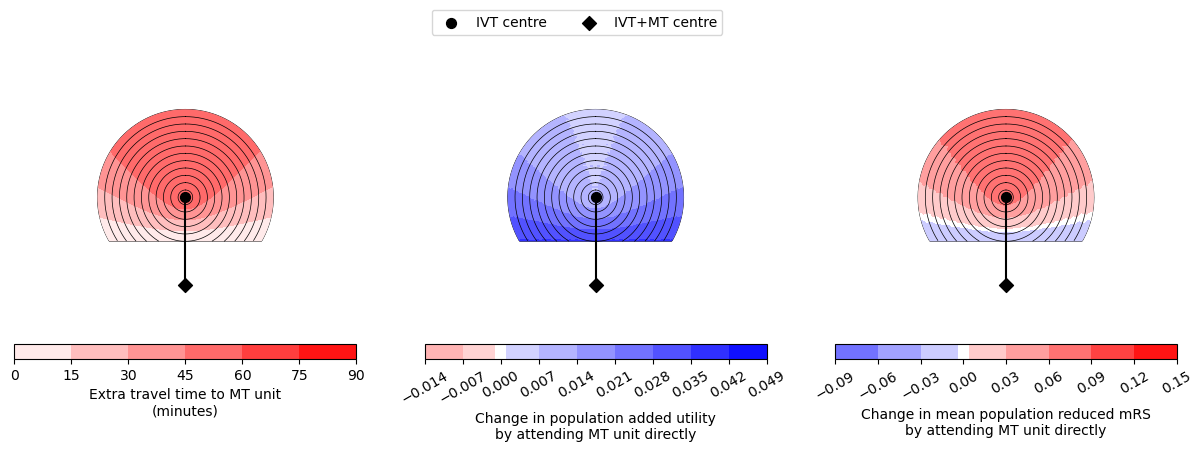

--------------------------------------------------
Time of travel from IVT to MT: 60
Time from onset to ambulance arrival:  60
Utility  0.0053  0.0357
mRS -0.0282  0.0801


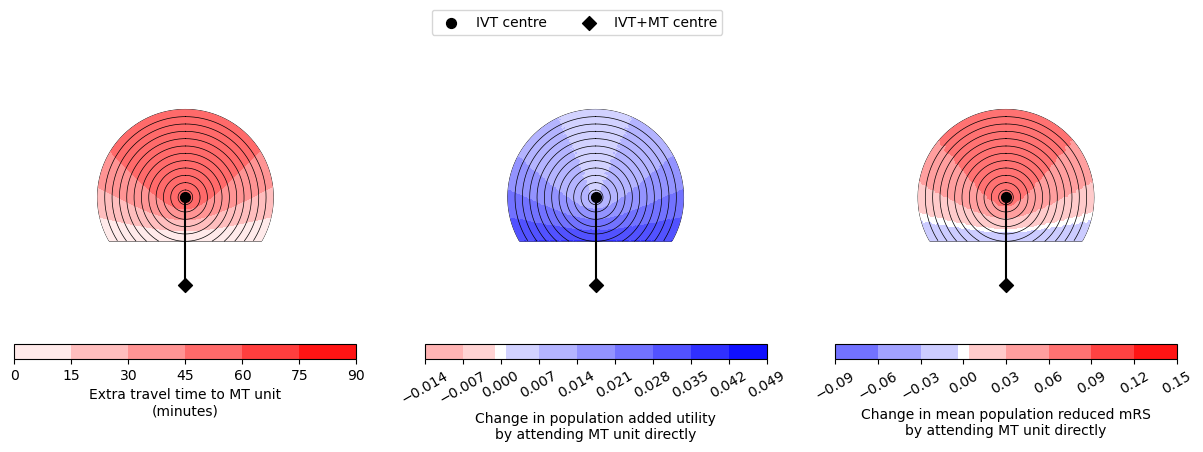

--------------------------------------------------
Time of travel from IVT to MT: 60
Time from onset to ambulance arrival:  90
Utility  0.0045  0.0353
mRS -0.0276  0.0810


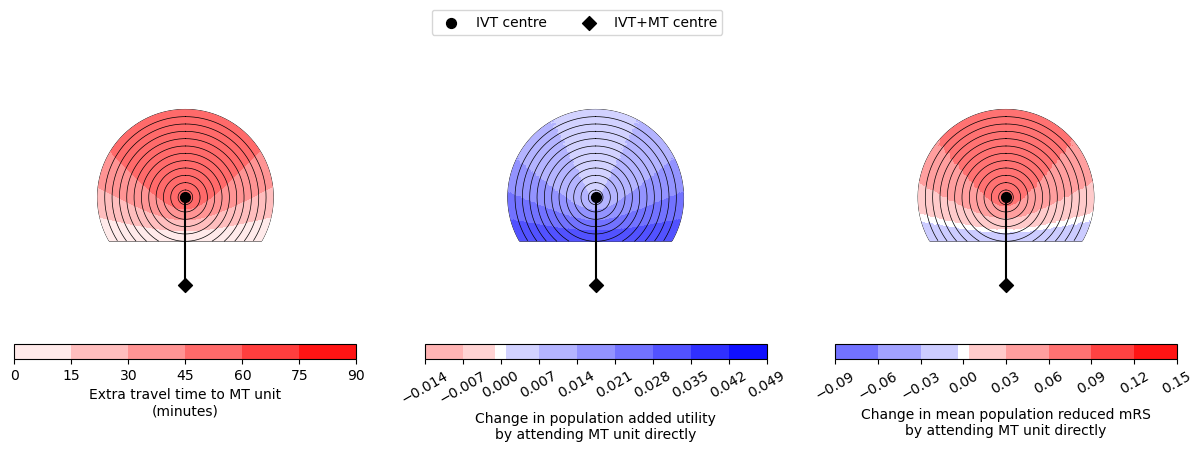

--------------------------------------------------
Time of travel from IVT to MT: 90
Time from onset to ambulance arrival:  30
Utility -0.0012  0.0447
mRS -0.0353  0.1278


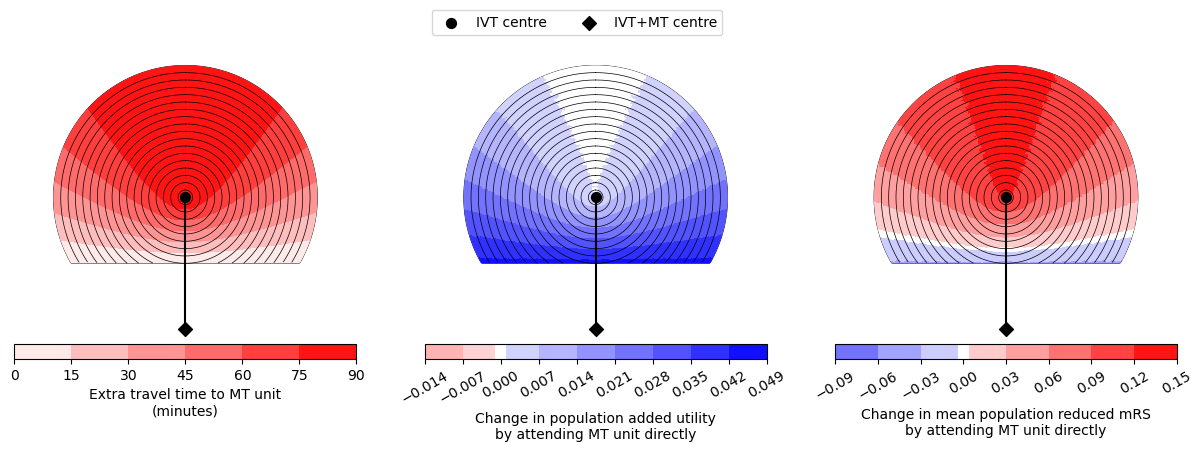

--------------------------------------------------
Time of travel from IVT to MT: 90
Time from onset to ambulance arrival:  60
Utility -0.0039  0.0440
mRS -0.0487  0.1278


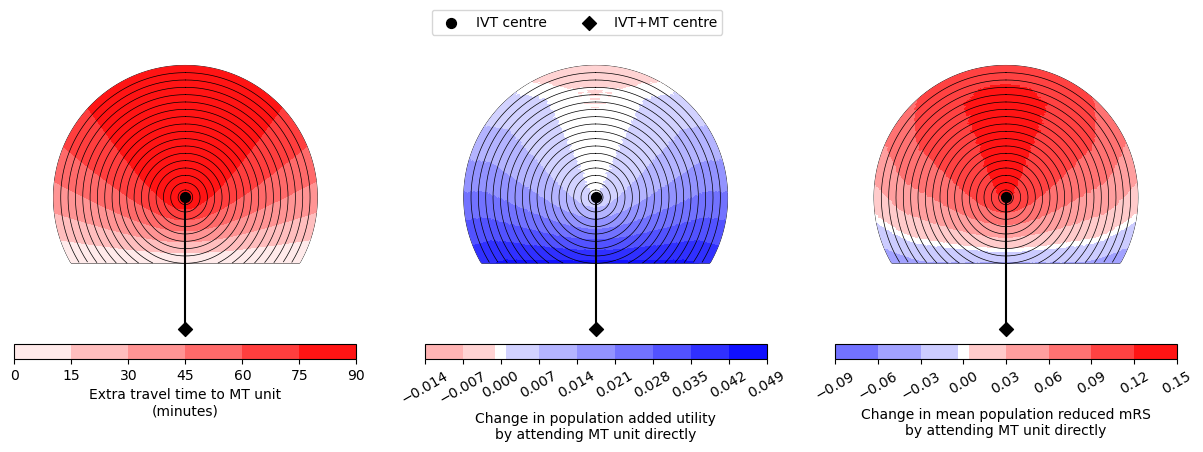

--------------------------------------------------
Time of travel from IVT to MT: 90
Time from onset to ambulance arrival:  90
Utility -0.0090  0.0435
mRS -0.0713  0.1278


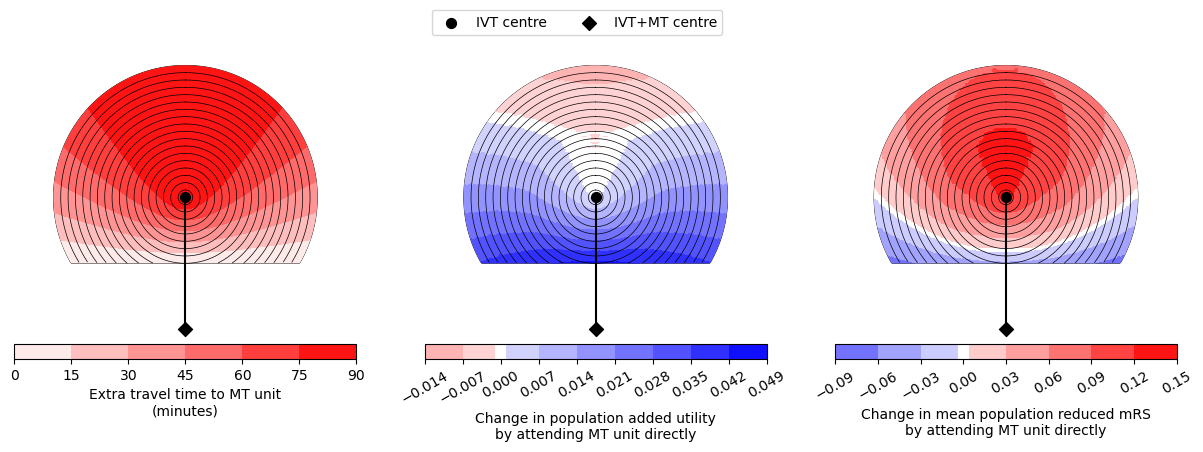

In [42]:
for time_travel_ivt_to_mt in time_list_travel_ivt_to_mt:
    # Recalculate some values: 
    ivt_coords = [0, 0]
    mt_coords  = [0, -time_travel_ivt_to_mt] 
    # Only calculate travel times up to this x or y displacement:
    time_travel_max = time_travel_ivt_to_mt 
    # Change how granular the grid is. 
    grid_step = 1 # minutes

    # Make the travel time grids: 
    (grid_time_travel_directly_to_ivt, 
    grid_time_travel_directly_to_mt,
    grid_time_travel_directly_diff, 
    extent) = \
    make_grids_travel_time(time_travel_ivt_to_mt, time_travel_max, 
                           ivt_coords, mt_coords, grid_step=1)
    
    # Find grid coordinates within the largest circle: 
    grid_mask = find_mask_within_flattened_circle(
        grid_time_travel_directly_diff, 
        grid_time_travel_directly_to_ivt, 
        time_travel_max)
    coords_valid = np.where(grid_mask<1)

    for time_onset_to_ambulance_arrival in (
        time_list_onset_to_ambulance_arrival):

        # Build a new dictionary of fixed times: 
        times_dir = {}
        for key in fixed_times:
            times_dir[key] = fixed_times[key]
        times_dir['onset_to_ambulance_arrival'] = time_onset_to_ambulance_arrival
        times_dir['travel_ivt_to_mt'] = time_travel_ivt_to_mt
        
        # Grids of times to treatment:
        (grid_time_ivt_at_ivtcentre,
        grid_time_ivt_at_ivt_then_mt_at_mtcentre,
        grid_time_ivt_at_mtcentre,
        grid_time_ivt_then_mt_at_mtcentre) = \
        make_grids_treatment_time(grid_time_travel_directly_to_ivt,
            grid_time_travel_directly_to_mt, times_dir)

        # Grids of changed outcomes
        # Case 1: IVT at the IVT centre, then MT at the IVT/MT centre
        grid_utility_case1, grid_mRS_case1 = find_grid_outcomes(
            outcome_model,
            grid_time_ivt_at_ivtcentre, 
            grid_time_ivt_at_ivt_then_mt_at_mtcentre, 
            patient_props
            )
        # Case 2: IVT at the IVT/MT centre, then MT at IVT/MT centre
        grid_utility_case2, grid_mRS_case2 = find_grid_outcomes(
            outcome_model,
            grid_time_ivt_at_mtcentre, 
            grid_time_ivt_then_mt_at_mtcentre, 
            patient_props
            )
        # Difference between them:
        grid_utility_diff = grid_utility_case2 - grid_utility_case1
        grid_mRS_diff     = grid_mRS_case2     - grid_mRS_case1


        print('-'*50)
        print(f'Time of travel from IVT to MT: {time_travel_ivt_to_mt:2d}')
        print(f'Time from onset to ambulance arrival: ',
              f'{time_onset_to_ambulance_arrival:2d}')
        
        print(f'Utility {np.min(grid_utility_diff[coords_valid]):7.4f} '+
              f'{np.max(grid_utility_diff[coords_valid]):7.4f}')
        print(f'mRS {np.min(grid_mRS_diff[coords_valid]):7.4f} '+
              f'{np.max(grid_mRS_diff[coords_valid]):7.4f}')
        

        # Plot setup:  
        fig, axs = plt.subplots(2, 3, figsize=(15,4), 
        gridspec_kw={'wspace':0.2, 'hspace':0.0, 'height_ratios':[20,1]})
        ax_time = axs[0,0]
        ax_time_cbar = axs[1,0]
        ax_util = axs[0,1]
        ax_util_cbar = axs[1,1]
        ax_mRS = axs[0,2]
        ax_mRS_cbar = axs[1,2]

        # Travel time:
        circle_plot(
            -grid_time_travel_directly_diff, 
            time_travel_ivt_to_mt, 
            time_travel_max, 
            time_step_circle, 
            vmin_time, 
            vmax_time, 
            ivt_coords=ivt_coords, 
            mt_coords=mt_coords,             
            extent=extent,
            imshow=0, 
            ax=ax_time, 
            cax=ax_time_cbar, 
            cmap=cmap_time,
            cbar_label='Extra travel time to MT unit\n(minutes)', 
            cbar_orientation='horizontal',
            n_contour_steps=6)

        # Draw legend now:
        fig.legend(loc='upper center', bbox_to_anchor=[0.5,1.0], ncol=2)

        # Utility:
        circle_plot(
            grid_utility_diff, 
            time_travel_ivt_to_mt, 
            time_travel_max, 
            time_step_circle, 
            vmin_util, 
            vmax_util, 
            ivt_coords=ivt_coords, 
            mt_coords=mt_coords,
            extent=extent,
            imshow=0, 
            ax=ax_util, 
            cax=ax_util_cbar, 
            cmap=cmap_util, 
            cbar_label=('Change in population added utility\n'+
                        'by attending MT unit directly'),
            cbar_orientation='horizontal',
            levels=levels_util,
            # cbar_format_str='{:3.3f}',
            cbar_ticks=np.arange(
                vmin_util, vmax_util+level_step_util, level_step_util))

        # mRS:
        circle_plot(
            grid_mRS_diff, 
            time_travel_ivt_to_mt, 
            time_travel_max, 
            time_step_circle, 
            vmin_mRS, 
            vmax_mRS, 
            ivt_coords=ivt_coords, 
            mt_coords=mt_coords,
            extent=extent,
            imshow=0, 
            ax=ax_mRS, 
            cax=ax_mRS_cbar, 
            cmap=cmap_mRS, 
            cbar_label='Change in mean population reduced mRS\n'+
                        'by attending MT unit directly',
            cbar_orientation='horizontal',
            # cbar_format_str='{:3.2f}', 
            levels=levels_mRS, 
            cbar_ticks=np.arange(
                vmin_mRS, vmax_mRS+level_step_mRS, level_step_mRS))
        

        for ax in [ax_time, ax_util, ax_mRS]:
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ['top', 'bottom', 'left', 'right']:
                ax.spines[spine].set_color('None')
            ax.set_ylim(-max(time_list_travel_ivt_to_mt)-10, 
                        +max(time_list_travel_ivt_to_mt)+10)

        # Rotate colourbar tick labels to prevent overlapping:
        for ax in [ax_util_cbar, ax_mRS_cbar]:
            for tick in ax.get_xticklabels():
                tick.set_rotation(30)
                
        filename = ('circle_plots'+
            f'_t-IVT-to-MT={time_travel_ivt_to_mt:2d}'+
            f'_t-onset-to-ambo={time_onset_to_ambulance_arrival:2d}')
        plt.savefig('./images/'+filename+'.jpg', dpi=300, bbox_inches='tight')
        plt.show()